In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy.optimize import differential_evolution
from numba import jit
import time, multiprocessing, pickle
from scipy.integrate import quad

from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

Nuc = Xe131

In [2]:
# To obtain the parameters of parameters for the asymptotic distribution of the test statistic.
# Note that we only choose less neutrino sources as inputs to save time, \
#     according to their impacts which can be somehow obtained from \
#     the 2nd component of DLLSRVecPlot.distributionPara's outputs.
def matOneHalfGen(mat):
    va, ve = np.linalg.eigh(mat)
    return [ve@np.diag(1/va)@np.transpose(ve), ve@np.diag(np.sqrt(va))@np.transpose(ve)]

def symMatGen(diagTerms, ijTerms):
    n = len(diagTerms)
    myMat = np.zeros((n,n))
    for i in range(0, n-1):
        myMat[i, i+1:] = ijTerms[i]
        myMat[i+1:, i] = ijTerms[i]
    myMat = myMat + np.diag(diagTerms)
    return myMat

def myMatGen(n, b0, deriAs, deri2As, sigmaTheta, sigmaAs, exposure):
    vList = np.sum(b0, axis=0)
    vInvList = 1/vList
    deriList = np.insert(b0,1,deriAs,axis=0)
    deriNuListT = np.transpose(deriList[2:])

    sigmaAs2 = sigmaAs*sigmaAs
    sigmaTheta2 = sigmaTheta*sigmaTheta

    tempVar1 = 0.5*sigmaAs2*deri2As*vInvList
    tempVar2 = np.sum(tempVar1*deriAs)
    temp = vInvList*(1 + tempVar1)
    tempMat = np.zeros((n,n))
    tempMat[0:2,0:2] = np.array([[0.,tempVar2],[tempVar2,np.sum(tempVar1*deri2As)]])
    ijList = [[np.sum(deriList[i]*deriList[j]*temp) for j in range(i+1,n)] for i in range(0,n-1)]
    diagTerms = np.array([np.sum(deriList[i]*deriList[i]*temp) for i in range(0,n)])
    lddTemp = symMatGen(diagTerms, ijList)
    ldd = lddTemp - tempMat 
    ldd = exposure*ldd + np.diag(np.append([0.],1/(np.append([sigmaAs], sigmaTheta)**2)))
    mu = exposure*np.array([np.sum(tempVar1*deri) for deri in deriList])

    nBin = len(vList)
    ijTerms = [[np.sum(deriNuListT[i]*deriNuListT[j]*sigmaTheta2) for j in range(i+1,nBin)] for i in range(0,nBin-1)]
    diagTerms = [np.sum(deriNuListT[i]*deriNuListT[i]*sigmaTheta2) for i in range(0,nBin)]
    varGauTermConst = np.outer(vInvList, vInvList)*(symMatGen(diagTerms, ijTerms) \
                     + (np.outer(deriAs, deriAs))*sigmaAs2- (0.5*sigmaAs2)**2*np.outer(deri2As, deri2As))
    varGauTermIJ = [[np.sum(np.outer(deriList[i], deriList[j])*varGauTermConst)\
                             for j in range(i+1,n)] for i in range(0,n-1)]
    varGauTermDiag = [np.sum(np.outer(deriList[i], deriList[i])*varGauTermConst)\
                             for i in range(0,n)]
    varGauTerm = symMatGen(varGauTermDiag, varGauTermIJ)
    varMat = exposure*lddTemp + exposure**2*varGauTerm
    
    return ldd, varMat, mu

class DLLSRVecPlot(object):
    
    def __init__(self, mDM, E_th, E_max, ne, selList):
        nunames, NuUnc, R_nu = BinnedNeutrinoRates2(E_th,E_max,ne,Nuc,Flux_norm)
        
        self._RNu = R_nu[selList]
        self._NuUncs = NuUnc[selList]
        iEnd = np.max([len(x[x>1.0e-10]) for x in self._RNu])
        self._RNu = self._RNu[:,:iEnd]
        self._sData, self._deriAs, self._deri2As = self._deriV0Gen(mDM, E_th,E_max,ne,iEnd)
    
    def _deriV0Gen(self, mDM, E_th, E_max, ne, iEnd):
        dd = 1.0e-4
        xList = np.array([-1.,0,1.])*dd + 1.
        yList = np.array([BinnedWIMPRate2(E_th,E_max,ne,np.array([mDM]),\
                               Nuc,C_SI,FormFactorHelm,\
                lambda v_min: MeanInverseSpeed_SHM(\
            v_min,sig_v=167.0*x,v_esc=533.0,v_lab=245.6))[1][0][:iEnd] \
                        for x in xList])
        deri1List = (yList[2]-yList[0])/(2*dd)
        deri2List = (yList[2]+yList[0]-2*yList[1])/(dd*dd)
        return yList[1], deri1List, deri2List
    
    def distributionPara(self, sigmaAs, exposure, sigma0):
        b = self._RNu
        sigmaTheta = self._NuUncs
        n = len(b)+2
        b0 = np.append([self._sData*10**(sigma0+45.)], b, axis=0)
        deriAs = self._deriAs*10**(sigma0+45.)
        deri2As = self._deri2As*10**(sigma0+45.)
        
        ldd, varMat, mu = myMatGen(n, b0, deriAs, deri2As, sigmaTheta, sigmaAs, exposure)
        nk = n - 2
        G3 = ldd.copy()[2:,2:]
        HMat = np.block([[np.zeros((2,2)), np.zeros((2,nk))],[np.zeros((nk,2)), np.linalg.inv(G3)]])
        lddInv, lddOneHalf = matOneHalfGen(ldd)
        varMatInv, varMatOneHalf = matOneHalfGen(varMat)
        varMatOneHalfInv = np.linalg.inv(varMatOneHalf)
        tmat = lddInv - HMat

        res1 = varMatOneHalf@(lddInv - HMat)@varMatOneHalf
        res2 = np.linalg.eigh(res1)
        orderList = np.flip(np.argsort(res2[0]))
        res2 = [res2[0][orderList], np.transpose(res2[1])[orderList]]
        res3 = varMatOneHalfInv@(mu+ldd@np.append([1.],np.zeros(n-1)))
        return [res2[0][0:2], res2[1][0:2], (res2[1][0:2]@res3)**2, res2[0]]
    
    def _matGen(self, b, sigmaTheta, sigmaAs, exposure, sigma0):
        b = self._RNu
        sigmaTheta = self._NuUncs
        n = len(b)+2
        b0 = np.append([self._sData*10**(sigma0+45.)], b, axis=0)
        deriAs = self._deriAs*10**(sigma0+45.)
        deri2As = self._deri2As*10**(sigma0+45.)
        
        ldd, varMat, mu = myMatGen(n, b0, deriAs, deri2As, sigmaTheta, sigmaAs, exposure)

        nk = n - 2
        G3 = ldd.copy()[2:,2:]
        HMat = np.block([[np.zeros((2,2)), np.zeros((2,nk))],[np.zeros((nk,2)), np.linalg.inv(G3)]])
        lddInv, lddOneHalf = matOneHalfGen(ldd)
        varMatInv, varMatOneHalf = matOneHalfGen(varMat)
        varMatOneHalfInv = np.linalg.inv(varMatOneHalf)
        tmat = lddInv - HMat
        
        return [tmat, ldd, varMatOneHalfInv, varMat, varMatOneHalfInv@mu]
    
# To collect the test statistic generated from MC pseudo-experiments
@jit(nopython=True)
def H0Func(datObs, RNu, nuiList, Uncs, exposure):
    temp = nuiList@RNu
    return - exposure*np.sum(datObs*(np.log(exposure)+np.log(temp))-temp)+ 0.5*np.sum(((1-nuiList)/Uncs)**2)

class MCCheck(object):
    
    def __init__(self, mDM, E_th, E_max, ne):
        self._mDM, self._E_th, self._E_max, self._ne= mDM, E_th,E_max,ne
        nunames, self._NuUnc, self._R_nu = BinnedNeutrinoRates2(E_th,E_max,ne,Nuc,Flux_norm)
        print('Neutrino sources: ', np.array(nunames))
        return None
        
    def _sigGen(self, x):
        return BinnedWIMPRate2(self._E_th, self._E_max, self._ne,np.array([self._mDM]),\
                               Nuc,C_SI,FormFactorHelm,\
                lambda v_min: MeanInverseSpeed_SHM(\
            v_min,sig_v=167.0*x,v_esc=533.0,v_lab=245.6))[1][0]
    
    def _datGenH0(self, RNu, Uncs, exposure):
        for i in range(100):
            nuiList = np.array(list(map(lambda d: np.random.normal(loc=1.,scale=d), Uncs)))
            if np.all(nuiList>0):
                break
        dat = nuiList@RNu
        return np.array(list(map(lambda d: np.random.poisson(lam=d), dat*exposure)))/exposure
    
    def _datGenH1(self, RNu, sigma0, Uncs, exposure):
        for i in range(100):
            nuiList = np.array(list(map(lambda d: np.random.normal(loc=1.,scale=d), Uncs)))
            if np.all(nuiList>np.append(np.zeros(len(nuiList)-1),[0.2])) and nuiList[-1]<3.:
                break
        datDM = self._sigGen(nuiList[-1])[:len(RNu[0])]*10**(sigma0+45.)
        dat = nuiList[:-1]@RNu + datDM
        return np.array(list(map(lambda d: np.random.poisson(lam=d), dat*exposure)))/exposure
    
    def _statisticGen(self, datObs, RNu, sigma0, Uncs, exposure):
        n = np.shape(Uncs)[0]
        H0Gen = lambda x: H0Func(datObs, RNu, x, Uncs[:-1], exposure)
        H1Gen = lambda x: self._H1Func(datObs, RNu, sigma0, x[0], x[1:], Uncs, exposure)

        boundsH0 = np.transpose([np.zeros(n-1)+1.0e-5, np.ones(n-1)*3.])
        boundsH1 = np.transpose([np.append(np.zeros(n)+1.0e-5, [0.2]), \
                                 np.append(np.append(np.array([1.0e2]),np.ones(n-1)*3.),[4.])])
        likeDeno = differential_evolution(H1Gen, boundsH1, tol=0, atol=0.01)
        likeNume = differential_evolution(H0Gen, boundsH0, tol=0, atol=0.01)
        #print(likeDeno," ",likeNume," ",[datDM])
        return [2*(likeNume.fun-likeDeno.fun), likeNume.x, likeDeno.x, datObs] 
    
    def _H1Func(self, datObs, RNu, sigma0, mu, nuiList, Uncs, exposure):
        datDM = self._sigGen(nuiList[-1])[:len(datObs)]*10**(sigma0+45.)
        temp = nuiList[:-1]@RNu + datDM*mu
        return - exposure*np.sum(datObs*(np.log(exposure)+np.log(temp))-temp) + 0.5*np.sum(((1-nuiList)/Uncs)**2)
    
    def H0StatGen(self, sigma0, exposure, sigmaAs, selList, n):
        RNu = self._R_nu[selList]
        NuUncs = self._NuUnc[selList]
        Uncs = np.append(NuUncs, [sigmaAs])
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNu])
        RNu = RNu[:,:iEnd]
        #datDM = self._sigGen(1.)[:iEnd]*10**(sigma0+45.)
        
        datObsList = np.array(list(map(lambda i: \
                self._datGenH0(RNu, NuUncs, exposure), range(n))))
        time_start = time.perf_counter()
        pool = multiprocessing.Pool(4)
        multiple_results = [pool.apply_async(\
                self._statisticGen, (datObsList[i], RNu, sigma0, Uncs, exposure))\
                                             for i in range(n)]
        pool.close()
        pool.join()
        H0Stat= [res.get() for res in multiple_results]
        #H1Stat = [self._statisticGen(datObsList[i], RNu, sigma0, Uncs, exposure) for i in range(n)]
        time_end = time.perf_counter()
        print("Time costed: {0} s.".format(time_end-time_start))
        return H0Stat
    
    def H1StatGen(self, sigma0, exposure, sigmaAs, selList, n):
        RNu = self._R_nu[selList]
        NuUncs = self._NuUnc[selList]
        Uncs = np.append(NuUncs, [sigmaAs])
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNu])
        RNu = RNu[:,:iEnd]
        #datDM = self._sigGen(1.)[:iEnd]*10**(sigma0+45.)
        
        datObsList = np.array(list(map(lambda i: \
                self._datGenH1(RNu, sigma0, Uncs, exposure), range(n))))
        time_start = time.perf_counter()
        pool = multiprocessing.Pool(4)
        multiple_results = [pool.apply_async(\
                self._statisticGen, (datObsList[i], RNu, sigma0, Uncs, exposure))\
                                             for i in range(n)]
        pool.close()
        pool.join()
        H1Stat= [res.get() for res in multiple_results]
        #H1Stat = [self._statisticGen(datObsList[i], RNu, sigma0, Uncs, exposure) for i in range(n)]
        time_end = time.perf_counter()
        print("Time costed: {0} s.".format(time_end-time_start))
        return H1Stat

# Functions for calculating the type II error
def cumFourierFunc(cList, phiList, x):
    quadFunc = lambda t: np.imag((1-np.exp(-1j*x*t))*\
        np.exp(-np.sum((cList*t*phiList)/(1j+2*cList*t)))/(np.prod(np.sqrt(1-2j*cList*t))*t))
    return (quad(quadFunc, 1.0e-6, 20.)[0])*2/(2*np.pi)

In [3]:
# np.argsort(np.abs(tempPara[1][0][2:]))[::-1] shows the order of impacts from different neutrino sources
Eth = E_th
mDM = 0.51
sigma0 = -44.16
exposure = 1.0e1
sigmaAs = 0.212
selList = np.linspace(0,14,15,dtype=int)
MC51 = MCCheck(mDM, Eth, E_max, ne)
LSR51 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList)
tempPara=LSR51.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,np.argsort(np.abs(tempPara[1][0][2:]))[::-1],\
 np.argsort(np.abs(tempPara[1][1][2:]))[::-1],cumFourierFunc(tempPara[0], tempPara[2], 9.)]

Neutrino sources:  ['pp' 'pep' 'hep' '7Be1' '7Be2' '8B' '13N' '15O' '17F' 'DSNB' 'Atm' 'GeoU'
 'GeoTh' 'GeoK' 'Reactor']


[[array([6.92330856, 0.95544706]),
  array([[-2.90731168e-02,  8.19070012e-01, -3.21991985e-01,
           4.27328122e-01,  3.52050939e-04, -2.00140166e-02,
           1.35111470e-01, -3.16032805e-03,  1.84887473e-02,
           1.50631348e-01,  3.76129723e-03, -2.38840528e-07,
           1.22702856e-06, -9.99693645e-03, -6.62969048e-03,
           1.04147393e-02, -5.19449534e-03],
         [ 8.12840086e-01,  1.14357694e-02,  2.97291022e-01,
           1.36633039e-01,  8.87513016e-04,  5.84783609e-02,
           1.89770859e-01, -4.94102485e-03,  4.16912978e-01,
           1.21895737e-01,  2.53858916e-03, -1.03864799e-06,
           2.66527379e-06, -3.22854708e-02, -2.43488845e-02,
           4.62701551e-02, -1.39350420e-02]]),
  array([ 0.01512133, 13.87716332]),
  array([ 6.92330856e+00,  9.55447056e-01,  2.22590991e-13,  5.46928272e-14,
          5.60129004e-16,  3.83160815e-17,  1.11317129e-17,  4.52661284e-18,
          2.85518317e-18,  2.09860271e-19, -3.60432827e-18, -5.93781348e

In [4]:
# The 5 neutrino sources we choose are more relevant to the test statistic.
# We try to make the type II error closed to 0.1
selList51 = np.array([0,1,4,6,7])
LSR51 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList51)
tempPara=LSR51.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,cumFourierFunc(tempPara[0], tempPara[2], 9.)]

[[array([7.63522434, 0.96644124]),
  array([[ 0.01004061, -0.82771789,  0.31818847, -0.42849924, -0.13743189,
          -0.02841564, -0.10115239],
         [-0.82508639, -0.00724409, -0.29987917, -0.13317487, -0.18115463,
          -0.42107454, -0.0373649 ]]),
  array([6.45220732e-04, 1.45522086e+01]),
  array([ 7.63522434e+00,  9.66441245e-01,  2.89589383e-12,  5.28207928e-14,
          5.53115281e-15, -3.77805201e-15, -2.23698692e-14])],
 0.09296869149170757]

In [5]:
Eth = E_th
mDM = 1.
sigma0 = -44.72
exposure = 1.0e1
sigmaAs = 0.212
selList = np.linspace(0,14,15,dtype=int)
MC1 = MCCheck(mDM, Eth, E_max, ne)
LSR1 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList)
tempPara=LSR1.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,np.argsort(np.abs(tempPara[1][0][2:]))[::-1],\
 np.argsort(np.abs(tempPara[1][1][2:]))[::-1],cumFourierFunc(tempPara[0], tempPara[2], 9.)]

Neutrino sources:  ['pp' 'pep' 'hep' '7Be1' '7Be2' '8B' '13N' '15O' '17F' 'DSNB' 'Atm' 'GeoU'
 'GeoTh' 'GeoK' 'Reactor']


[[array([14.79884174,  2.23706643]),
  array([[-3.21936389e-01, -8.84067028e-01,  2.62718871e-03,
          -1.08291632e-01,  7.00934665e-04, -5.19411743e-04,
           2.72807764e-02, -3.11910105e-01,  1.14597483e-02,
          -6.03674737e-02, -1.68181715e-03, -6.89519280e-06,
          -3.85450871e-06, -2.62950787e-02, -1.34447943e-02,
           1.64650845e-03, -1.90332758e-02],
         [ 5.83971986e-01, -2.96263928e-01, -2.48628082e-02,
           7.05541828e-01,  6.28915332e-03,  1.76877607e-02,
           2.83164821e-02, -4.61045083e-02, -1.70259288e-01,
           1.86051941e-01,  5.94277054e-03,  8.08447844e-06,
          -4.26168113e-05, -4.46132566e-03,  3.24307531e-02,
          -4.56814291e-02, -5.21516707e-02]]),
  array([2.92476486, 0.99450045]),
  array([ 1.47988417e+01,  2.23706643e+00,  7.36448501e-14,  9.65306226e-15,
          2.51666722e-15,  1.78830168e-15,  3.01307733e-16,  3.13341568e-17,
          1.86544139e-17,  7.24620298e-18,  3.70930763e-18, -7.32225758e

In [6]:
selList1 = np.array([1,5,6,7])
LSR1 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList1)
tempPara=LSR1.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,cumFourierFunc(tempPara[0], tempPara[2], 9.)]

[[array([16.15118488,  2.32622068]),
  array([[-3.08369896e-01, -8.89803978e-01, -4.40630660e-02,
          -3.19354175e-01,  9.37685111e-02,  2.08737335e-02],
         [ 5.86468823e-01, -2.56834256e-01,  7.12057597e-01,
          -3.30354475e-02, -2.86309037e-01, -5.08178557e-04]]),
  array([2.92159169, 1.16135788]),
  array([ 1.61511849e+01,  2.32622068e+00,  9.91770409e-14,  2.56536635e-14,
         -1.05322813e-14, -5.45080337e-13])],
 0.10275074055250874]

In [7]:
Eth = E_th
mDM = 5.5
sigma0 = -45.38
exposure = 1.0e1
sigmaAs = 0.212
selList = np.linspace(0,14,15,dtype=int)
MC55 = MCCheck(mDM, Eth, E_max, ne)
LSR55 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList)
tempPara=LSR55.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,np.argsort(np.abs(tempPara[1][0][2:]))[::-1],\
 np.argsort(np.abs(tempPara[1][1][2:]))[::-1],cumFourierFunc(tempPara[0], tempPara[2], 9.)]

Neutrino sources:  ['pp' 'pep' 'hep' '7Be1' '7Be2' '8B' '13N' '15O' '17F' 'DSNB' 'Atm' 'GeoU'
 'GeoTh' 'GeoK' 'Reactor']


[[array([3.04934238, 0.99377098]),
  array([[-4.06579539e-02, -9.08178852e-01, -2.28640257e-04,
           2.50789473e-02, -1.98138256e-02,  1.38611760e-04,
          -1.93806702e-03, -4.13757884e-01, -4.27664353e-03,
           2.05004832e-02,  5.77591842e-04,  3.72158765e-05,
           1.57376376e-04,  1.51649988e-02,  5.88387921e-03,
          -6.80951350e-04,  2.51628293e-02],
         [ 1.51622183e-01, -4.16319905e-01, -2.23838662e-04,
          -2.18339604e-02, -2.01972453e-02, -3.88723176e-04,
           9.70790425e-04,  8.95081556e-01,  3.44492175e-03,
          -1.39768276e-02, -3.96638153e-04, -4.08621798e-05,
          -3.82332246e-04, -1.87803405e-02, -6.38625377e-03,
           3.88248632e-04, -3.21014714e-02]]),
  array([ 0.41641323, 14.95377502]),
  array([ 3.04934238e+00,  9.93770984e-01,  1.78449677e-13,  1.38287895e-14,
          9.15055935e-15,  7.47267670e-16,  3.77125502e-16,  2.39728197e-17,
          2.31254351e-18,  4.18614112e-21,  6.58241288e-22, -2.49087845e

In [8]:
selList55 = np.array([1,2,5,7,14])
LSR55 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList55)
tempPara=LSR55.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,cumFourierFunc(tempPara[0], tempPara[2], 9.)]

[[array([3.05964906, 0.99405606]),
  array([[-0.04124606, -0.90944177,  0.02638212, -0.01930796, -0.41151561,
          -0.01046782,  0.02628588],
         [ 0.15578322, -0.41309865, -0.01075851, -0.02014554,  0.89600606,
          -0.02380515, -0.03414631]]),
  array([ 0.40670476, 14.98977802]),
  array([ 3.05964906e+00,  9.94056063e-01,  5.74823481e-16,  1.76954248e-17,
         -7.16447943e-17, -3.10481691e-15, -2.16337093e-14])],
 0.099623380088401]

In [9]:
Eth = 4.
mDM = 10.
sigma0 = -47.6
exposure = 1.0e4
sigmaAs = 0.212
selList10 = np.array([0,1,2,3])
MC10 = MCCheck(mDM, Eth, E_max, ne)
LSR10 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList10)
tempPara=LSR10.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,np.argsort(np.abs(tempPara[1][0][2:]))[::-1],\
 np.argsort(np.abs(tempPara[1][1][2:]))[::-1],cumFourierFunc(tempPara[0], tempPara[2], 9.)]

Neutrino sources:  ['hep' '8B' 'DSNB' 'Atm']


[[array([70.5712259 ,  0.18650668]),
  array([[-2.50754567e-01, -9.67629377e-01, -1.74420149e-02,
           9.89354106e-06, -4.73059558e-03,  2.21118227e-02],
         [-8.54005412e-01,  2.27369695e-01, -4.55867392e-01,
           4.23063352e-05,  6.95654081e-02, -7.95195025e-02]]),
  array([ 1.57660749, 19.82256879]),
  array([ 7.05712259e+01,  1.86506677e-01,  2.09724643e-14,  3.66549284e-15,
          2.96406560e-21, -4.73219657e-15])],
 array([3, 0, 2, 1]),
 array([0, 3, 2, 1]),
 0.09659289804861737]

In [10]:
Eth = 4.
mDM = 100.
sigma0 = -48.6
exposure = 1.0e4
sigmaAs = 0.212
selList100 = np.array([0,1,2,3])
MC100 = MCCheck(mDM, Eth, E_max, ne)
LSR100 = DLLSRVecPlot(mDM, Eth, E_max, ne, selList100)
tempPara=LSR100.distributionPara(sigmaAs, exposure, sigma0)
[tempPara,np.argsort(np.abs(tempPara[1][0][2:]))[::-1],\
 np.argsort(np.abs(tempPara[1][1][2:]))[::-1],cumFourierFunc(tempPara[0], tempPara[2], 9.)]

Neutrino sources:  ['hep' '8B' 'DSNB' 'Atm']


[[array([1.12368922, 0.23803762]),
  array([[-8.33499832e-01,  4.46762663e-01,  2.22108565e-02,
          -1.35031436e-05,  1.35827199e-03, -3.24323890e-01],
         [ 2.62581187e-01,  8.32962795e-01, -3.53513261e-02,
          -3.36383571e-05, -1.24076342e-01,  4.69658862e-01]]),
  array([16.26233254,  0.90721897]),
  array([ 1.12368922e+00,  2.38037623e-01,  4.22842315e-16,  2.53394954e-23,
         -1.44842161e-15, -2.09702347e-14])],
 array([3, 0, 2, 1]),
 array([3, 2, 0, 1]),
 0.10185072389483968]

In [11]:
labelList = [51,1,55,10,100]
selList = [eval('selList'+str(i)) for i in labelList]
MCList = [eval('MC'+str(i)) for i in labelList]
sigma0List = [-44.16,-44.72,-45.38,-47.6,-48.6]
exposureList = [10.,10.,10.,1e4,1e4]

In [12]:
H1DatList = [MCList[i].H1StatGen(sigma0List[i], exposureList[i], sigmaAs,\
                        selList[i], 10000) for i in range(len(MCList))]

Time costed: 18730.815479147015 s.
Time costed: 13211.849110741983 s.
Time costed: 12692.211118937004 s.
Time costed: 11973.298958687985 s.
Time costed: 9006.441803958965 s.


In [13]:
mypath = os.path.join(os.path.abspath(os.path.pardir),'data', 'MC')
myData = H1DatList
myFile = open(os.path.join(mypath,'MCLSRH1.pickle'), 'wb')
pickle.dump(myData, myFile)
myFile.close()

In [14]:
i=2
H0Dat55 = MCList[i].H0StatGen(sigma0List[i], exposureList[i], sigmaAs,\
                        selList[i], 1000)

Time costed: 1485.2681365910103 s.


In [15]:
from scipy.stats import ncx2
import matplotlib.pyplot as plt

def H0StatPlot(H0Stat, xmax):
    dmax=500.
    H0Stat = np.array(list(map(lambda x: 1.0e-6 if x<0. else x, H0Stat)))
    H0StatX = np.linspace(0.,dmax,1000)
    DatX = np.array(list(map(lambda x: [x,x], H0StatX[1:-1]))).flatten()
    DatX = np.append([H0StatX[0]], np.append(DatX, [H0StatX[-1]]))
    H0StatY = np.histogram(H0Stat, bins=H0StatX)[0]
    H0StatY = 1/(np.sum(H0StatY)*(H0StatX[1]-H0StatX[0]))*H0StatY
    DatY = np.array(list(map(lambda x: [x,x], H0StatY))).flatten()
    
    fig, ax = plt.subplots()
    x = np.linspace(1.0e-6,xmax,1000)
    y = 0.5*ncx2.pdf(x,df=1,nc=0)
    ax.plot(x, y, color='black', linestyle='-', label='Distribution')
    ax.plot(DatX, DatY, color='Red', linestyle='-.', label='Data')
    ax.legend()
    ax.set(xlim=(-0.5,xmax), ylim=(1e-4,1e1))
    plt.yscale('log')
    plt.show()

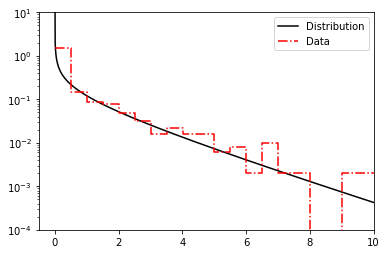

In [16]:
H0StatPlot(np.array([d[0] for d in H0Dat55]), 10.)